In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import glob
from dask import dataframe as df

In [368]:
from dask.distributed import Client
client = Client(scheduler_file= '/your_path/scheduler.json')
client

<Client: 'tcp://203.247.189.224:44435' processes=16 threads=576, memory=298.02 GiB>

# dealing with model data

In [ ]:
def def_process_coords(exceptcv=[]):
    def process_coords(ds, except_coord_vars=exceptcv):
        coord_vars = []
        for v in np.array(ds.coords):
            if not v in except_coord_vars:
                coord_vars += [v]
        for v in np.array(ds.data_vars):
            if not v in except_coord_vars:
                coord_vars += [v]
        return ds.drop(coord_vars)
    return process_coords


In [ ]:
## define function to read in files
def read_in(var, exceptcv, domain='lnd/', freq='day_1/', stream='h6', chunks=dict(time=365), ens_s=-20, ens_e=-10):
    ens_dir = "/your path to store original cesm2-LE output/"
    histens_names = [member.split('archive/')[1][:-1]
                     for member in sorted(glob.glob(ens_dir + "b.e21.BHIST*LE2*[!old][!tmp]/"))][10:]
    projens_names = [member.split('archive/')[1][:-1] for member in sorted(
        glob.glob(ens_dir + "b.e21.BSSP370*.f09_g17*[!old][!tmp]/"))][10:]
    hist_ncfiles = []
    proj_ncfiles = []
    for i in np.arange(ens_s, ens_e):
        hist_fnames = sorted(glob.glob(
            ens_dir + histens_names[i] + "/" + domain + "proc/tseries/" + freq + "*" + stream + var + "*"))
        proj_fnames = sorted(glob.glob(
            ens_dir + projens_names[i] + "/" + domain + "proc/tseries/" + freq + "*" + stream + var + "*"))
        hist_ncfiles.append(hist_fnames)
        proj_ncfiles.append(proj_fnames)
    ens_numbers = [members.split('LE2-')[1]
                   for members in histens_names][ens_s:ens_e]
    hist_ds = xr.open_mfdataset(hist_ncfiles,
                                chunks=chunks,
                                preprocess=def_process_coords(exceptcv),
                                combine='nested',
                                concat_dim=[[*ens_numbers], 'time'],
                                parallel=True)
    proj_ds = xr.open_mfdataset(proj_ncfiles,
                                chunks=chunks,
                                preprocess=def_process_coords(exceptcv),
                                combine='nested',
                                concat_dim=[[*ens_numbers], 'time'],
                                parallel=True)
    if freq == 'day_1/':
        hist_ds = hist_ds.isel(time=np.arange(1, hist_ds.time.shape[0]))
        proj_ds = proj_ds.isel(time=np.arange(1, proj_ds.time.shape[0]))
        hist_ds['time'] = hist_ds.time.get_index('time').shift(-1, 'D')
        proj_ds['time'] = proj_ds.time.get_index('time').shift(-1, 'D')
    if freq == 'month_1/':
        hist_ds['time'] = hist_ds.time.get_index('time').shift(-1, 'M')
        proj_ds['time'] = proj_ds.time.get_index('time').shift(-1, 'M')
    ens_ds = xr.concat((hist_ds, proj_ds), 'time')
    ens_ds = ens_ds.rename({'concat_dim': 'ensemble'})
    return ens_ds


In [ ]:
# define the interpolation method
example_ds = xr.open_mfdataset(glob.glob('/your_path_to_store_original_cesm2_output/*TLAKE.1850*')[0],
                             cache=False)
zlake = example_ds.ZLAKE.load()
dzlake = example_ds.DZLAKE.load()

from scipy.interpolate import pchip_interpolate
def interp1d_np_gufunc(y, x, xi):
    if np.isnan(y).any():
        return np.empty(xi.shape) * np.nan
    else:
        y_inped = pchip_interpolate(x, y, xi)
        y_inped[xi > x.max()] = np.nan
        return y_inped

In [ ]:
variables = ['TLAKE']
exceptcv = ['time', 'levlak','lat', 'lon', *variables]
tlake_day_ds = read_in(var = '.TLAKE.', 
                    exceptcv = exceptcv,
                     domain = 'lnd/',
                     freq = 'day_1/',
                     stream = 'h5',
                    ens_s = 0,
                    ens_e = 90)

/home/huanglei/usr/anaconda3/envs/Jun2023/lib/python3.9/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


# Lake Michigan

In [3]:
# The in-situ lake temperature data for Lake Michigan were obtained from the NOAA National Centers for Environmental Information Archives, with the accession ID 0190726. 
ncfiles = sorted(glob.glob('/proj/lhuang/LENS/OBS/US_lake_insitu_temp/0190726/2.2/data/0-data/glerl_southern_lake_michigan_temperature_mooring*.nc'))

In [4]:
# check what depths for the observation
depths = []
for i in ncfiles:
    depths.append(xr.open_mfdataset(i).z.values)
depths

[array([ 28.6,  33.1,  38.1,  43.1,  48.1,  58.1,  68.1,  78.1,  88.1,
         98.1, 107.5]),
 array([ 28.6,  33.1,  38.1,  43.1,  48.1,  58.1,  68.1,  78.1,  88.1,
         98.1, 107.5]),
 array([ 26.6,  31.1,  36.1,  41.1,  46.1,  56.1,  66.1,  76.1,  86.1,
         96.1, 105.6]),
 array([ 22.6,  27.1,  32.1,  37.1,  42.1,  52.1,  62.1,  72.1,  82.1,
         92.1, 101.6]),
 array([ 23.1,  27.6,  32.6,  37.6,  42.6,  52.6,  62.6,  72.6,  82.6,
         92.6, 102.1]),
 array([ 22.6,  32.6,  37.6,  42.6,  52.6,  72.6,  82.6,  92.6, 102.6,
        112.6, 142.6]),
 array([ 13.9,  23.9,  28.9,  33.9,  43.9,  63.9,  73.9,  83.9,  93.9,
        103.9, 133.9]),
 array([ 15.4,  25.4,  30.4,  35.4,  45.4,  65.4,  75.4,  85.4,  95.4,
        105.4, 135.4]),
 array([ 17.5,  27.4,  32.5,  37.4,  47.4,  77.7,  87.7,  97.7, 107.7,
        152.7]),
 array([  9.6,  14.6,  19.6,  24.6,  29.6,  39.6,  59.6,  79.6,  99.6,
        119.6, 144.6]),
 array([ 10.2,  15.2,  20.2,  25.2,  30.2,  40.2,  60.2, 

In [5]:
# the original data is high frequency, so firstly convert it into daily data and interpolate the data on ceertain depths
for i in ncfiles:
    x = xr.open_dataset(i).sea_water_temperature.resample(time = '1D').mean()
    y = x.interp(z = np.arange(0,151,10), method='slinear', kwargs = {"fill_value": "extrapolate"})
    y.where(y.z >= x.z.values.min() - 5).to_netcdf('/proj/lhuang/LENS/OBS/US_lake_insitu_temp/0190726/daily_data_LeiHuang/' +i.split('0-data/')[1][:-3] + '_daily.nc')
    del x, y


read in daily data (processed by myself) and check it is whether interpolated properly

In [6]:
wtemp_day = xr.open_mfdataset(sorted(glob.glob('/proj/lhuang/LENS/OBS/US_lake_insitu_temp/0190726/daily_data_LeiHuang/glerl_southern_lake_michiga*daily.nc'))).sea_water_temperature.load()
wtemp_day = wtemp_day.where(wtemp_day > 0)

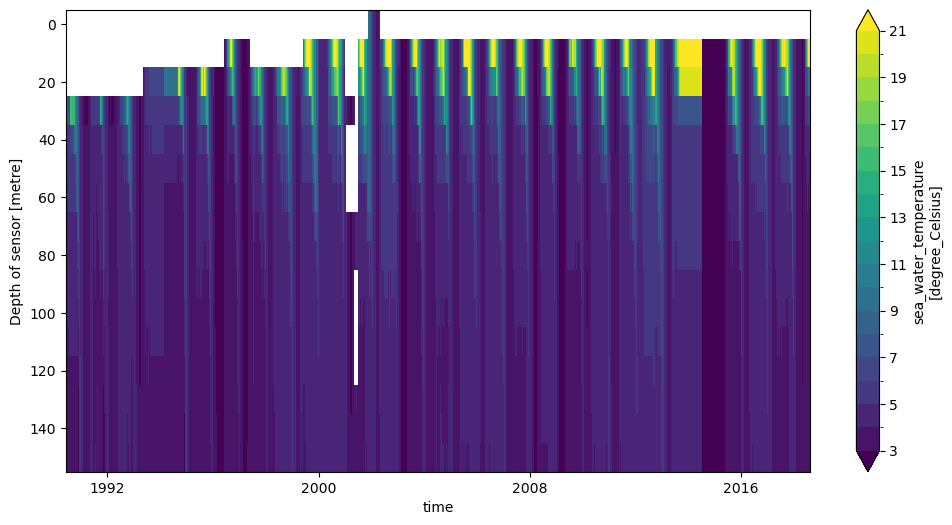

In [9]:
# plot out the mesh grid figure
# it turns out for the upper part (20 m in which no observation), the extrapolation not works properly
fig, axs = plt.subplots(1,1, figsize = (12,6)) 
wtemp_day.T.plot(ax = axs, levels = np.arange(3,22))
axs.invert_yaxis()
plt.show()

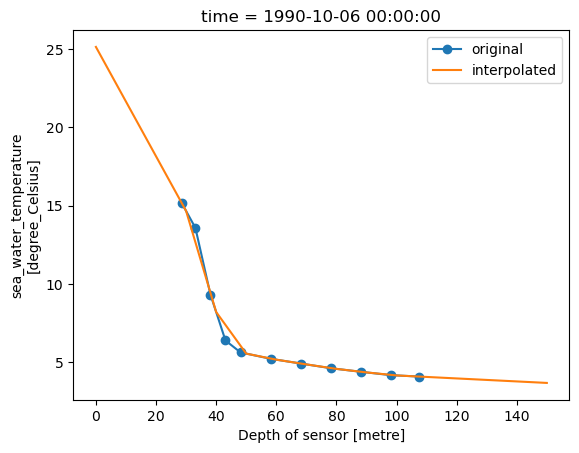

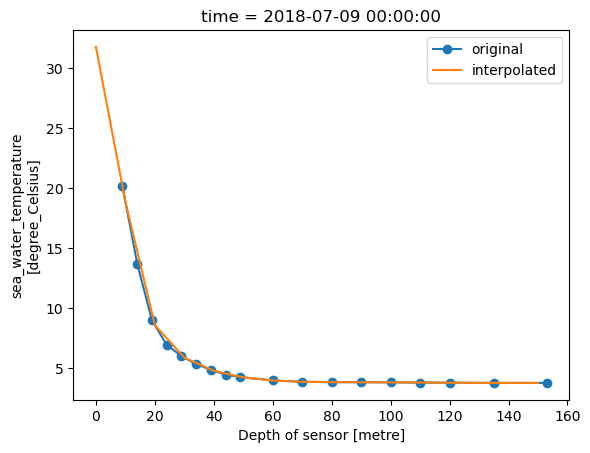

In [19]:
# to double check why extrapolation on the top 20 m not work
# it turns out the extrapolation are too much for the top of the layer
x = xr.open_dataset(ncfiles[0]).sea_water_temperature.resample(time = '1D').mean()
x[120,:].plot(marker = 'o', label = 'original')
wtemp_day[120,:].plot(label = 'interpolated')
plt.legend()
plt.show()
# same thing, but different time
x = xr.open_dataset(ncfiles[-1]).sea_water_temperature.resample(time = '1D').mean()
x[-30,:].plot(marker = 'o', label = 'original')
wtemp_day[-30,:].plot(label = 'interpolated')
plt.legend()
plt.show()

In [15]:
# retieve model output near observation site which has similar depth
# since 90 members' daily temperature data are too large, beyond the ram capacity, so we use 20 members, which do not alter validation result
tlake_day_michigan = tlake_day_ds.TLAKE.sel(lat = slice(42,43), lon = slice(272, 273), time = slice('1990-02-01','2018-09-01'))[-20:,:,:,0,0].compute()  - 273.15
# mask out that surface layers temperature minus zeros which is due to lake ice present, we mask these minus zero temperatures, to avoid its influence on interpolation
tlake_day_michigan = tlake_day_michigan.where(tlake_day_michigan > 0)
# now interpolate the data
tlake_day_michigan_inped = tlake_day_michigan.rename({'levlak': 'z'}).assign_coords({'z': zlake.sel(lat = slice(42,43), lon = slice(272, 273)).values[:,0,0]}).interp(z = np.arange(8,151,10), method='slinear', kwargs={'fill_value':'extrapolate'})
# mask out minus temperatures, these temperatures are unreasonable due to extrapolation
tlake_day_michigan_inped = tlake_day_michigan_inped.where(tlake_day_michigan_inped > 0)

In [60]:
wtemp_mon = wtemp_day.resample(time = '1M').mean()
tlake_mon_michigan_inped = tlake_day_michigan_inped.resample(time = '1M').mean()

Figure S2

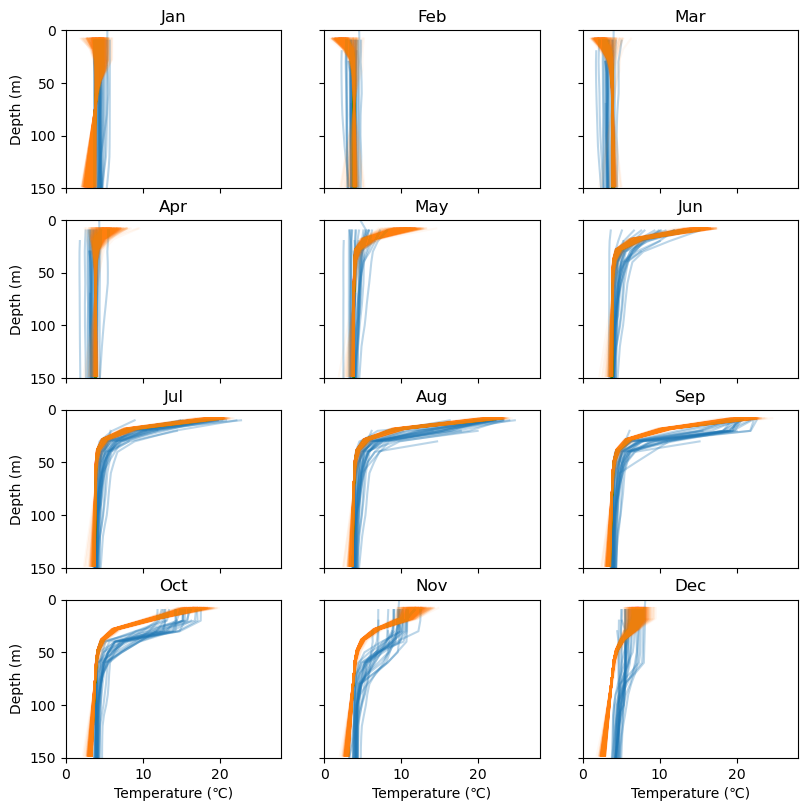

In [64]:
cm = 1/2.54
fig, axs = plt.subplots(4,3, figsize = (24 * cm, 24 * cm), sharex = True, sharey = True)
for mon in np.arange(12):
    x = wtemp_mon[wtemp_mon.time.dt.month == mon + 1, :]
    y = tlake_mon_michigan_inped[:, tlake_mon_michigan_inped.time.dt.month == mon + 1, :]
    for i in np.arange(x.shape[0]):
        axs[mon//3, mon % 3].plot(x[i,:], x.z, c = 'C0', alpha = 0.3)
    for j in np.arange(y.shape[0]):
        for k in np.arange(y.shape[1]):
            axs[mon//3, mon % 3].plot(y[j,k, :], y.z, c = 'C1', alpha = 0.05)
[ax.set_title('') for ax in axs.reshape(-1,)]
#[ax.invert_yaxis() for ax in axs.reshape(-1,)]
[ax.set_xlabel(u'Temperature (\u2103)') for ax in axs[-1,:]]
[ax.set_ylabel('Depth (m)') for ax in axs[:, 0]]
[ax.set_xlim(0,28) for ax in axs.reshape(-1,)]
[ax.set_ylim(150, 0 ) for ax in axs.reshape(-1,)]
#[axs.reshape(-1,)[mon].set_title('') for mon in np.arange()]
[axs.reshape(-1,)[mon].set_title(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug', 'Sep', 'Oct','Nov', 'Dec'][mon]) for mon in np.arange(12)]
plt.show()

Sparkling Lake

In [106]:
#The in-situ lake temperature data for Lake Sparkling were obtained from the Environmental Data Initiative data portal (Magnuson et al. 2023).
# Magnuson, J.J. and others 2023. North Temperate Lakes LTER: High Frequency Water Temperature Data - Sparkling Lake Raft 1989 - current ver 24. Environmental Data Initiative. Dataset. https://doi.org/10.6073/pasta/52ceba5984c4497d158093f32b23b76d.
summer_lake_temp_sparkling_day = pd.read_csv('/proj/lhuang/LENS/OBS/US_lake_insitu_temp/ntl5_1_v8_LakeSparkling.csv')
summer_lake_temp_sparkling_day['sampledate'] = pd.to_datetime(summer_lake_temp_sparkling_day['sampledate'])
summer_lake_temp_sparkling_day = summer_lake_temp_sparkling_day.set_index(pd.MultiIndex.from_frame(summer_lake_temp_sparkling_day[['sampledate','depth']]))
summer_lake_temp_sparkling_day = summer_lake_temp_sparkling_day['wtemp'].unstack(level = -1)

summer_lake_temp_sparkling_day_array = xr.DataArray(data=summer_lake_temp_sparkling_day.values,
             dims = ('time', 'depth'),
             coords = {'time':summer_lake_temp_sparkling_day.index.values,
                       'depth':summer_lake_temp_sparkling_day.columns.values} 
             )

summer_lake_temp_sparkling_day_array_inped = summer_lake_temp_sparkling_day_array[np.isnan(summer_lake_temp_sparkling_day_array)\
                                                .sum('depth') < 32, :]\
                                                    .interpolate_na(dim='depth', fill_value="extrapolate")\
                                                        .interp(depth = np.arange(0,18.01,0.2), kwargs={"fill_value": "extrapolate"})

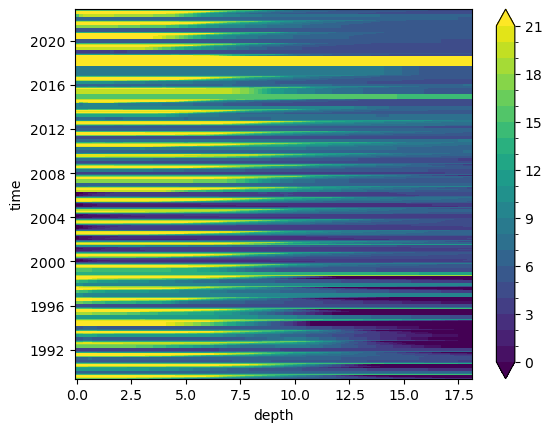

In [107]:
summer_lake_temp_sparkling_day_array_inped.plot(levels = np.arange(0,22), cmap = 'viridis')

In [ ]:
# retieve model output near observation site which has similar depth
# since 90 members' daily temperature data are too large, beyond the ram capacity, so we use 20 members, which do not alter validation result
tlake_day_sparkling = tlake_day_ds.TLAKE.sel(lat = slice(45.5,46.5), lon = slice(269.8, 270.8), time = slice('2004-01-01','2023-12-31'))[-20:,:,:,0,0].compute()  - 273.15
# mask out that surface layers temperature minus zeros which is due to lake ice present, we mask these minus zero temperatures, to avoid its influence on interpolation
tlake_day_sparkling = tlake_day_sparkling.where(tlake_day_sparkling > 0)
# now interpolate the data
tlake_day_sparkling_inped = tlake_day_sparkling.rename({'levlak': 'z'}).assign_coords({'z': zlake.sel(lat = slice(45.5,46.5), lon = slice(269.8, 270.8)).values[:,0,0]}).interp(z = np.arange(11), method='slinear', kwargs={'fill_value':'extrapolate'})
# mask out minus temperatures, these temperatures are unreasonable due to extrapolation
tlake_day_sparkling_inped = tlake_day_sparkling_inped.where(tlake_day_sparkling_inped > 0)

summer_lake_temp_sparkling_mon = summer_lake_temp_sparkling_day_array_inped.resample(time = '1M').mean()
tlake_mon_sparkling_inped = tlake_day_sparkling_inped.resample(time = '1M').mean()

Figure S3

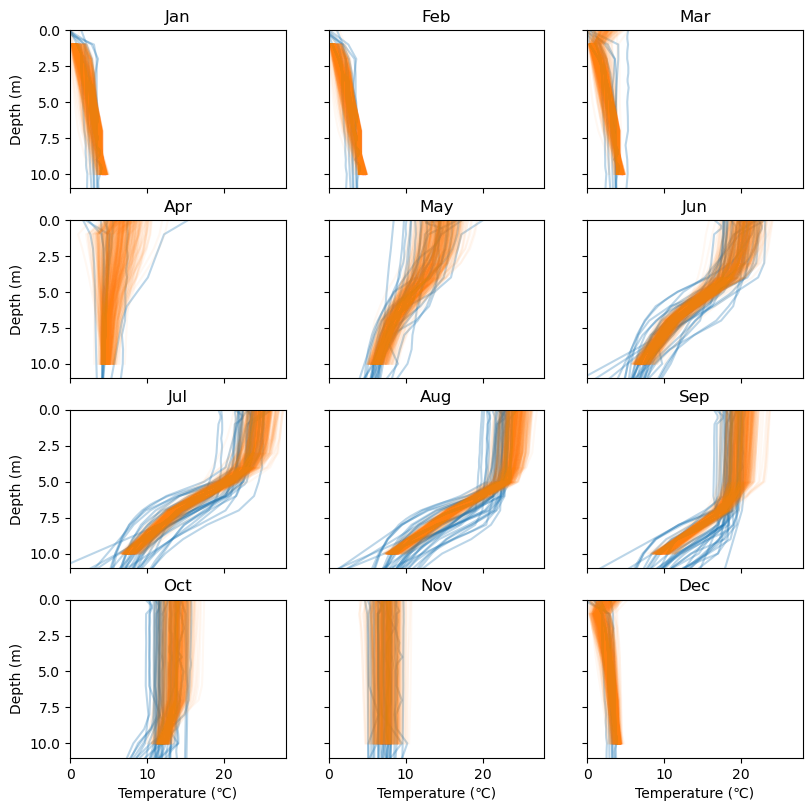

In [232]:
cm = 1/2.54
fig, axs = plt.subplots(4,3, figsize = (24 * cm, 24 * cm), sharex = True, sharey = True)
for mon in np.arange(12):
    x = summer_lake_temp_sparkling_mon[summer_lake_temp_sparkling_mon.time.dt.month == mon + 1, :]
    y = tlake_mon_sparkling_inped[:, tlake_mon_sparkling_inped.time.dt.month == mon + 1, :]
    for i in np.arange(x.shape[0]):
        if ~np.isnan(x[i,:]).all():
            axs[mon//3, mon % 3].plot(x[i,:].dropna('depth'), x.depth[~np.isnan(x[i,:])], c = 'C0', alpha = 0.3)
    for j in np.arange(y.shape[0]):
        for k in np.arange(y.shape[1]):
            axs[mon//3, mon % 3].plot(y[j,k, :], y.z, c = 'C1', alpha = 0.05)
[ax.set_title('') for ax in axs.reshape(-1,)]
#[ax.invert_yaxis() for ax in axs.reshape(-1,)]
[ax.set_xlabel(u'Temperature (\u2103)') for ax in axs[-1,:]]
[ax.set_ylabel('Depth (m)') for ax in axs[:, 0]]
[ax.set_xlim(0,28) for ax in axs.reshape(-1,)]
[ax.set_ylim(11, 0 ) for ax in axs.reshape(-1,)]
#[axs.reshape(-1,)[mon].set_title('') for mon in np.arange()]
[axs.reshape(-1,)[mon].set_title(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug', 'Sep', 'Oct','Nov', 'Dec'][mon]) for mon in np.arange(12)]
plt.show()